An Benchark example from Davies and Rawlinson, Geology 2014.
======
This notebook reproduces the 2D instantaneous flow model with a composite Newtonian and non-Newtonian rheology shown in Figure DR6 of [Davies and Rawlinson (2014)](http://geology.gsapubs.org/content/early/2014/10/17/G36093.1.abstract).  Rheological parameters are consistent with [Karato and Wu (1993)](http://science.sciencemag.org/content/260/5109/771), with prefactors chosen to produce a minimum diffusion creep viscosity of 5 x 10^19 Pa.s within the asthenosphere and dislocation creep dominating within the edge driven convection cell.  

**References**

1. D. Rhodri Davies and Nicholas Rawlinson, On the origin of recent intraplate volcanism in Australia. Geology, December 2014, v. 42, p. 1031-1034, doi:10.1130/G36093.1 
2. Karato, Shun-ichiro, and Patrick Wu. Rheology of the Upper Mantle: A Synthesis. Science 260, no. 5109 (1993): 771-78. http://www.jstor.org/stable/2881160.

In [1]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

/Users/lmoresi/+Underworld/underworld2/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Set simulation parameters.

In [2]:
# physical parameters
g        = 9.8      # [m/(s.s)],   gravity 
alpha    = 3*1e-5   # [K^-1],      thermal expansivity coefficient
kappa    = 1e-6     # [m.m/s],     thermal diffusivity
rho0     = 3300.    # [kg/m^3],    reference density
Temp_Min = 300.0    # [K],         surface temperature, 26.85C, 0C = 273.15K
Temp_Max = 1573.0   # [K],         mantle temperature
R        = 8.3145   # [J/(K.mol)], gas constant

deltaTemp = Temp_Max - Temp_Min

In [3]:
ageC = 100.*1e6*(60.*60.*24*365) # in seconds, 100 Myr, thermal aqge of cratonic lithosphere, left hand side
ageP =  20.*1e6*(60.*60.*24*365) # in seconds,  20 Myr, Palaeozoic lithosphere, right hand side; 
transLength = 200.*1e3           # transition length, 200 km

#length in [km]
boxLength = 2.1 #2100e3  # x 1e3 m = 2,100 km
boxHeight = 0.7 #700e3   # x 1e3 m =   700 km
minCoord = [-boxLength/2., -boxHeight]  # centre box at zero
maxCoord = [ boxLength/2., 0]
aspectRatio = boxLength/boxHeight

unitRes     = 128  
resolution  = [int(unitRes*aspectRatio),unitRes]

In [4]:
# scale vectors for 1 cm/yr
# v = (kappa / depth) * v' [m/s]
# [cm/yr] = (1e2cm/m).(60*60*24*365s/yr)[m/s]
velScalingFactor = (kappa/(boxHeight*1e6))*(1e2*(60*60*24*365))

Create mesh and finite element variables
------

In [5]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = resolution, 
                                 minCoord    = minCoord, 
                                 maxCoord    = maxCoord,
                               ) 

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [6]:
# initialise fields
temperatureField.data[:]    = 0.
temperatureDotField.data[:] = 0.
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.

In [7]:
#mesh.reset()

In [8]:
with mesh.deform_mesh():
    mesh.data[:,0] = mesh.data[:,0] * np.exp(mesh.data[:,0]*mesh.data[:,0]) / np.exp(maxCoord[0]*maxCoord[0])
    mesh.data[:,1] = mesh.data[:,1] * np.exp(mesh.data[:,1]*mesh.data[:,1]*2) / np.exp(boxHeight*boxHeight*2)


In [9]:
figsize=(900.,300.)


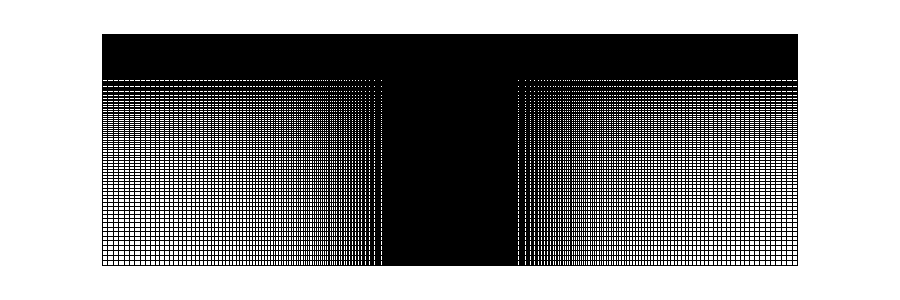

In [10]:
figMesh = glucifer.Figure( figsize=figsize )
figMesh.append( glucifer.objects.Mesh(mesh)) 
figMesh.show()

**Initialise & apply boundary conditions on the temperature Field**

In [11]:
# calculate half-space cooling model
for index, coord in enumerate(mesh.data):
    depth  = -1.0*coord[1]*1e6  # in [m]
    xCoord = coord[0]*1e6
    if xCoord < -transLength/2:
        temp = deltaTemp*math.erf(depth/(2.*math.sqrt(kappa*ageC)))/deltaTemp
    elif xCoord < transLength/2:
        # average between craton the palaeozoic lithosphere
        phi = (xCoord + transLength/2)/transLength  
        age = (1.-phi) * ageC + phi * ageP
        temp = deltaTemp*math.erf(depth/(2.*math.sqrt(kappa*age)))/deltaTemp
    else:
        temp = deltaTemp*math.erf(depth/(2.*math.sqrt(kappa*ageP)))/deltaTemp
    temperatureField.data[index] = temp

In [12]:
iWalls  = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls  = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
topWall = mesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof = ( jWalls, ) )

**Plot initial temperature**


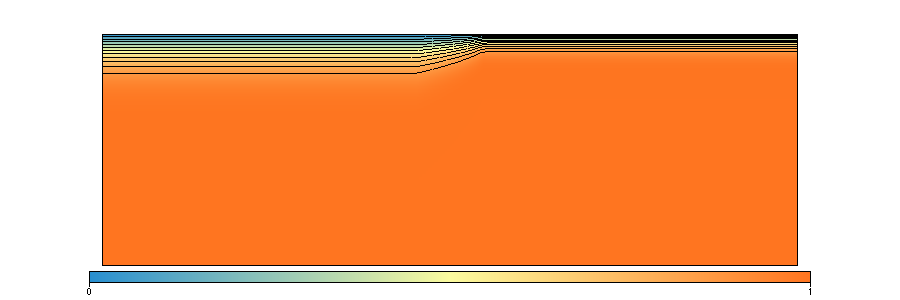

In [13]:
figtemp = glucifer.Figure(figsize=figsize)
figtemp.append( glucifer.objects.Surface(mesh, temperatureField) )
figtemp.append( glucifer.objects.Contours(mesh, temperatureField, interval=(100/deltaTemp), 
                                          limits=(0.,(1400-300)/deltaTemp), colours='Black', colourBar=False))
figtemp.show()

**Define the rheology**

In [14]:
# strain rate invariant
strainRateFn              = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)
strainRate_2ndInvariantFn_scaled = strainRate_2ndInvariantFn * (kappa / ((boxHeight*1e6)**2))

In [15]:
# hydrostatice pressure 
yCoord = fn.input()[1]*1e6
z_hat  = -1.0*(yCoord)
P_stat = rho0 * g * z_hat

In [16]:
# adiabatic gradiet to temperature solution, 0.5 K/km
Tm = (z_hat/1e3)*0.5+(temperatureField*deltaTemp)+Temp_Min

In [17]:
# limiters
eta_max = 1e24 # Pa.s, maximum viscosity
eta_min = 1e19 # Pa.s, minimum viscosity

In [18]:
# Diffusion creep
E_diff = 300.*1e3     # J/mol, activation energy
V_diff = 4.5/(1e2**3) # m^3/mol, activation volume
A_diff = 4.0e-10      # Pa^-1.s^-1, prefactor
n_diff = 1.

In [19]:
diffusionCreep  = 0.5*fn.math.pow(A_diff,(-1./n_diff))
diffusionCreep *= fn.math.exp((E_diff+P_stat*V_diff)/(n_diff*R*Tm))
diffusionCreep *= fn.math.pow((strainRate_2ndInvariantFn_scaled+1.0e-24),(1-n_diff)/n_diff)

In [20]:
# Dislocation creep
E_disl = 540.*1e3     # J/mol, activation energy
V_disl = 10./(1e2**3) # m^3/mol, activation volume
A_disl = 1.0e-15      # Pa^-n.s^-1, prefactor
n_disl = 3.5

In [21]:
dislocationCreep  = 0.5*fn.math.pow(A_disl,(-1./n_disl))
dislocationCreep *= fn.math.exp((E_disl+P_stat*V_disl)/(n_disl*R*Tm))
dislocationCreep *= fn.math.pow((strainRate_2ndInvariantFn_scaled+1.0e-24),(1-n_disl)/n_disl)

In [22]:
creep_harmonic = fn.math.pow((1./diffusionCreep + 1./dislocationCreep)/2.,-1)

In [23]:
fn_viscosity = fn.misc.max(fn.misc.min(creep_harmonic, eta_max), eta_min )/eta_min

In [24]:
viscosity = glucifer.objects.Surface(mesh, fn_viscosity*eta_min, logScale=True, valueRange=[5e19, 5e20], )
viscosity.colourBar["position"] = 0.0
viscosity.colourBar["size"] = [0.8,0.01]
viscosity.colourBar["tickvalues"] = [5, 10, 50]
viscosity.colourBar["align"] = "right"

figEta = glucifer.Figure(figsize=figsize, title='Viscosity field, Temperature contours')
figEta.append( viscosity)
figEta.append( glucifer.objects.Contours(mesh, temperatureField, interval=(100/deltaTemp), 
                                         limits=(0.,(1400-300)/deltaTemp), colours='Black', colourBar=False))
figEta.append( glucifer.objects.Contours(mesh, temperatureField, interval=(100/deltaTemp), 
                                         limits=(0.,(1400-300)/deltaTemp), colours='Black', colourBar=False))


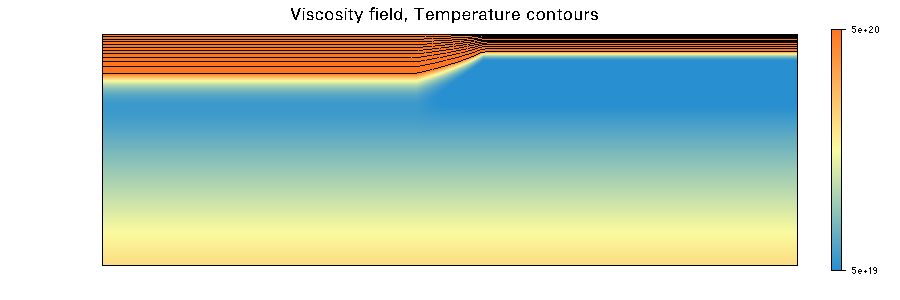

In [25]:
figEta.show()

**Define density, gravity and buoyancy force**

In [26]:
eta0 = eta_min
Ra   = (alpha*rho0*g*deltaTemp*((boxHeight*1e6)**3)) / (eta0*kappa)

In [27]:
densityFn = Ra*temperatureField
gravity = ( 0.0, 1.0 )
buoyancyFn = gravity*densityFn

**Setup a Stokes system**

In [28]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                               conditions = [freeslipBC,],
                             fn_viscosity = fn_viscosity, 
                             fn_bodyforce = buoyancyFn,
                          )

In [29]:
solver = uw.systems.Solver(stokes)

In [30]:
if uw.rank()==0:
    solver.set_inner_method("lu")

**Set up and solve the Stokes system**

In [31]:
solver.solve(nonLinearIterate=True)


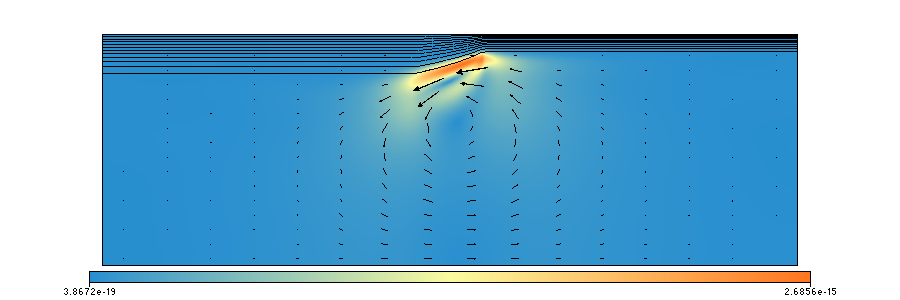

In [32]:
figStrainRateAndVel = glucifer.Figure(figsize=figsize)
figStrainRateAndVel.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariantFn_scaled) )
figStrainRateAndVel.append( glucifer.objects.VectorArrows(mesh, velocityField*velScalingFactor ) )
figStrainRateAndVel.append( glucifer.objects.Contours(mesh, temperatureField, interval=(100/deltaTemp), 
                                                      limits=(0.,(1400-300)/deltaTemp), colours='Black', colourBar=False))
figStrainRateAndVel.show()


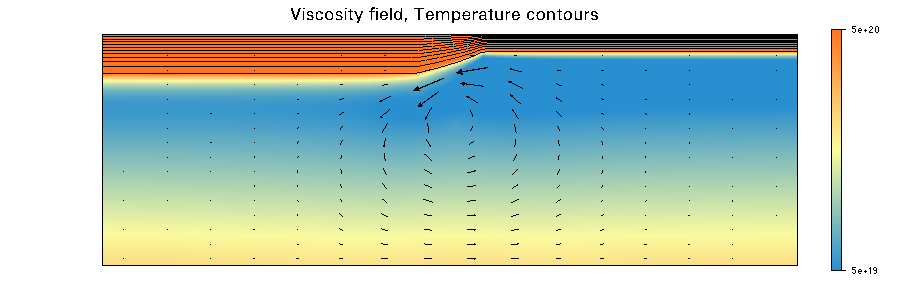

In [33]:
figEta.append( glucifer.objects.VectorArrows(mesh, velocityField*velScalingFactor ) )
figEta.show()

**Visualise the deformation mechanism**

In [34]:
# visualise the deformation mechanism
eta_min_filter = (fn_viscosity*eta_min <= eta_min)
eta_max_filter = (fn_viscosity*eta_min >= eta_max)
eta_dif_filter = (diffusionCreep <= dislocationCreep) 
eta_dis_filter = (dislocationCreep < diffusionCreep)

fn_defMech = fn.branching.conditional(  ( (eta_min_filter, 0),
                                          (eta_max_filter, 1),
                                          (eta_dif_filter, 2),
                                          (         True , 3) ) )

In [35]:
# red = max viscosity, blue = diffusion creep, grey = dislocation creep 
deformation = glucifer.objects.Surface(mesh, fn_defMech, onMesh=True, colours = 'Red Blue Grey', discrete=True)
deformation.colourBar["position"] = 0.0
deformation.colourBar["size"] = [0.8,0.01]
deformation.colourBar["align"] = "right"

figMechField = glucifer.Figure(figsize=figsize, title='Deformation Mechanism')
# contours of temperature at 100 degree intervals
figMechField.append( glucifer.objects.Contours(mesh, temperatureField, interval=(100/deltaTemp), 
                                          limits=(0.,(1400-300)/deltaTemp), colours='Black', colourBar=False))
# deformation mechanism field
figMechField.append( deformation )


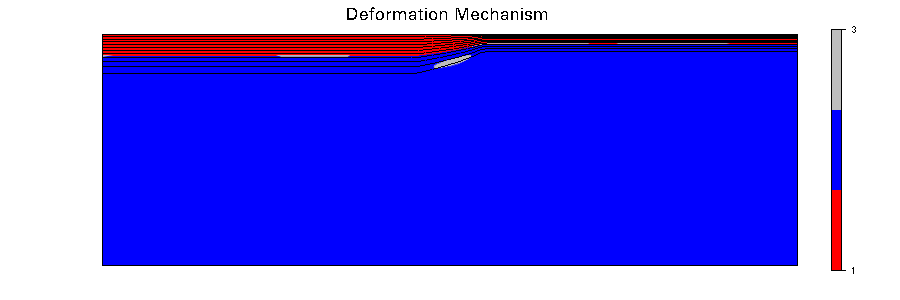

In [36]:
figMechField.show()